<a href="https://colab.research.google.com/github/GergelyTuri/fiberphotometry/blob/main/notebooks/video_velocity_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analyzing mouse velocity
* 8/27 setting up
* 9/4 added to `fiberphotometry` repo
* 9/19 adding analysis tools to fiberphotometry -- compute velocity is still broken.

In [1]:
!git clone https://github.com/GergelyTuri/sleep.git
%cd sleep
!pip install .

Cloning into 'sleep'...
remote: Enumerating objects: 273, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 273 (delta 15), reused 20 (delta 8), pack-reused 242
Receiving objects: 100% (273/273), 1.08 MiB | 11.08 MiB/s, done.
Resolving deltas: 100% (141/141), done.
/content/sleep
Processing /content/sleep
  Preparing metadata (setup.py) ... done
  Created wheel for sleep: filename=sleep-0.1-py3-none-any.whl size=1000 sha256=018b656898d33d530411867f9022af7fc1fd18628c85394e325ef83c1b53530a
  Stored in directory: /tmp/pip-ephem-wheel-cache-rs3g3ypz/wheels/10/eb/42/5281370ac4a2d7b033087761ebaa8f968a9ef5108cbc009a46
Successfully built sleep


In [2]:
%cd ..

/content


In [3]:
!git clone https://github.com/GergelyTuri/fiberphotometry.git
%cd fiberphotometry
!pip install .

Cloning into 'fiberphotometry'...
remote: Enumerating objects: 190, done.
remote: Counting objects: 100% (190/190), done.
remote: Compressing objects: 100% (136/136), done.
remote: Total 190 (delta 89), reused 141 (delta 48), pack-reused 0
Receiving objects: 100% (190/190), 23.08 MiB | 27.23 MiB/s, done.
Resolving deltas: 100% (89/89), done.
/content/fiberphotometry
Processing /content/fiberphotometry
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 kB 997.1 kB/s eta 0:00:00
  Created wheel for fiber-photometry-analysis: filename=fiber_photometry_analysis-0.1-py3-none-any.whl size=8440 sha256=90236e15f9d4d91d07d0bfaa55eaa648ddeb422673f077065a37d11c2a5427d9
  Stored in directory: /tmp/pip-ephem-wheel-cache-7cp_alkq/wheels/4b/b6/cf/916d1f43d06b8bc573d2ec7471e525018bf5ea7bcf83b8e670
Successfully built fiber-photometry-analysis


In [20]:
%cd /content/fiberphotometry/
!git pull

/content/fiberphotometry
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 4 (delta 3), reused 4 (delta 3), pack-reused 0
Unpacking objects: 100% (4/4), 414 bytes | 414.00 KiB/s, done.
From https://github.com/GergelyTuri/fiberphotometry
   5f48ba8..1cf0c82  main       -> origin/main
Updating 5f48ba8..1cf0c82
Fast-forward
 src/behavior_dlc.py | 3 ++-
 1 file changed, 2 insertions(+), 1 deletion(-)


In [1]:
from os.path import join
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sleep.base import core
from fiberphotometry.src import video
from fiberphotometry.src.behavior_dlc import Behavior as b
%matplotlib inline

In [ ]:
# def pairwise_dist(x_coords):
    """Computes consecutive pairwise differences in a Series.

    NOTE: This is a helper function for distance_moved.

    Args:
        x_coords: pandas Series
            A one-dimensional ndarray of x coordinates, over time.

    Returns:
        dx: pandas Series
            A series containing all the values x[i] - x[i-1]

    """
    x_coords = x_coords.astype(float)
    delta_x = (np.roll(x_coords, -1) - x_coords).shift(1)
    return delta_x

# def distance_moved(x_coords, y_coords):
    """Computes the distance moved per frame

    Args:
        x_coords: pandas Series
            A one-dimensional ndarray of x coordinates, over time.

        y_coords:
            A one-dimensional ndarray of y coordinates, over time.

    Returns
        Series containing distance moved per frame

    """
    if len(x_coords) != len(y_coords):
      raise ValueError("x_coords and y_coords are not of equal length!")

    delta_x = pairwise_dist(x_coords.astype(float))
    delta_y = pairwise_dist(y_coords.astype(float))
    dist_moved = delta_x**2 + delta_y**2
    dist_moved = dist_moved.apply(np.sqrt)
    return dist_moved

# def compute_velocity(dist_moved, framerate=10):
    """
    Args:
        dist_moved: pandas Series
            A one-dimensional ndarray containing distance moved.

        framerate: int, optional, default: 10
            The frame rate corresponding to the dist_moved Series.

    Returns:
        velocity: pandas Series
            A one-dimensional ndarray containing velocity.
    """
    velocity = dist_moved.apply(lambda x: x * framerate)
    return velocity

# def define_immobility(velocity, min_dur=1, min_vel=2, framerate=10, min_periods=1):
    """Define time periods of immobility based on a rolling window of velocity.

    A Mouse is considered immobile if velocity has not exceeded min_vel for the
    previous min_dur seconds.

    Default values for min_dur and min_vel are taken from:
    Stefanini...Fusi et al. 2018 (https://doi.org/10.1101/292953)

    Args:
        velocity: pandas Series
            A one-dimensional ndarray of the velocity data.

        min_dur: int, optional, default: 1
            The minimum length of time in seconds in which velocity must be low.

        min_vel: int, optional, default: 2
            The minimum velocity in cm/s for which the mouse can be considered
            mobile.

        framerate: int, optional, default: 10
            The frame rate of the velocity Series. Default is 10 fps.

        min_periods: int, optional, default: 1
            Minimum number of datapoints needed to determine immobility. This
            value is needed to define immobile time bins at the beginning of the
            session. If min_periods=8, then the first 8 time bins will be be
            considered immobile, regardless of velocity.

    Returns:
        mobile_immobile: pandas Series
            A one-dimensional ndarray of 0's and 1's, where 1 signifies immobile
            times and 0 signifies mobile times.

    """
    window_size = framerate * min_dur
    rolling_max_vel = velocity.rolling(window_size,
                                       min_periods=min_periods).max()
    mobile_immobile = (rolling_max_vel < min_vel).astype(int)

    return mobile_immobile

In [7]:
dr = core.GoogleDrive()
mnt = dr.mount_drive()

Mounted at /gdrive


In [2]:
# h5 = '/gdrive/Shareddrives/Turi_lab/Data/fiber_photometry/test_recordings/1aflox22a_1-230819-160741/EEGFP1c-230804-141830_1aflox22a_1-230819-160741_Cam1DLC_snapshot-200000.h5'
# tdt_path = '/gdrive/Shareddrives/Turi_lab/Data/fiber_photometry/test_recordings/1aflox22a_1-230819-160741'

h5 = '/gdrive/Shareddrives/Turi_lab/Data/fiber_photometry/test_recordings/1aflox22a_1-230819-160056/dlc/table/EEGFP1c-230804-141830_1aflox22a_1-230819-160056_Cam1DLC_snapshot-1000.h5'
tdt_path = '/gdrive/Shareddrives/Turi_lab/Data/fiber_photometry/test_recordings/1aflox22a_1-230819-160056'

In [3]:
# initailizing the class
beh = b(f_path=h5)
# loading the the data
data = beh.data

In [ ]:
data.keys()

In [4]:
vid = video.Video(tdt_path)
fr = vid.frame_rate()

Found Synapse note file: /gdrive/Shareddrives/Turi_lab/Data/fiber_photometry/test_recordings/1aflox22a_1-230819-160056/Notes.txt
read from t=0s to t=365.35s


In [5]:
coords = data[(data.columns.values[0][0],
                 'head_midpoint', 'x')]
pdist = beh.pairwise_dist(coords)
dist_moved = beh.distance_moved(data[(data.columns.values[0][0],
                 'head_midpoint', 'x')],
               data[(data.columns.values[0][0],
                       'head_midpoint', 'y')])
dist_moved.sum()

15391.730122086503

<Axes: >

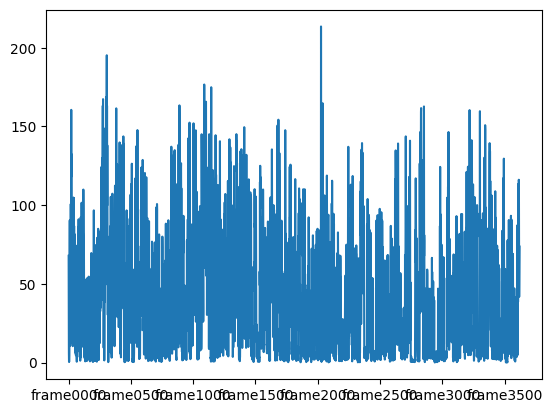

In [6]:
x_coords = data[(data.columns.values[0][0],
                 'head_midpoint', 'x')]
y_coords = data[(data.columns.values[0][0],
                 'head_midpoint', 'y')]
velo = beh.compute_velocity(x_coords, y_coords, fr)
mean_velo = velo.mean()
mean_velo
velo.plot()

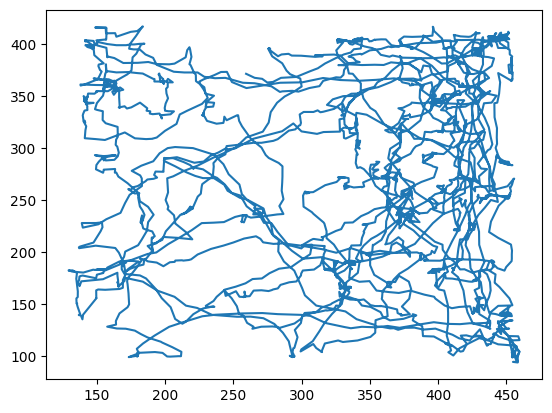

In [7]:
plt.plot(data[(data.columns.values[0][0],
                 'head_midpoint', 'x')],
               data[(data.columns.values[0][0],
                       'head_midpoint', 'y')])

<Axes: >

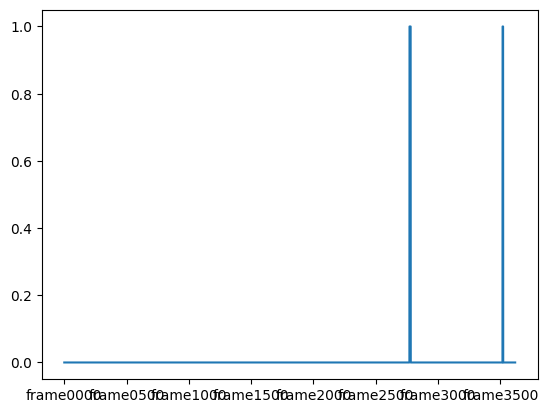

In [8]:
mob = beh.define_immobility(x_coords, y_coords)
mob.plot()

(-0.1, 1.2)

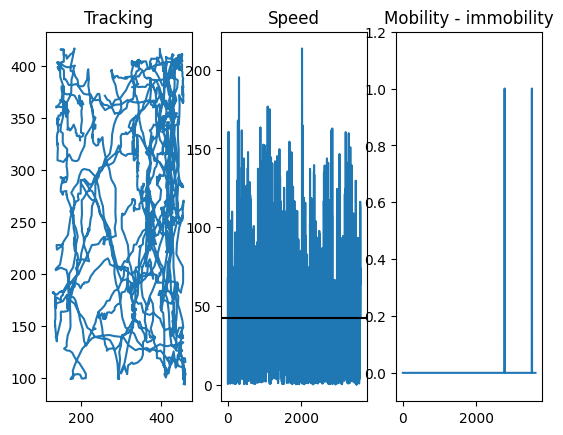

In [10]:
fig, axs = plt.subplots(ncols=3)
axs[0].plot(data[(data.columns.values[0][0],
                 'head_midpoint', 'x')],
               data[(data.columns.values[0][0],
                       'head_midpoint', 'y')])
axs[0].set_title('Tracking')
dist = beh.distance_moved(data[(data.columns.values[0][0],
                              'head_midpoint', 'x')],
                      data[(data.columns.values[0][0],
                              'head_midpoint', 'y')])
x = np.linspace(0, len(data.index), num=len(data.index))
velo = beh.compute_velocity(x_coords, y_coords, fr)
axs[1].plot(x, velo)
axs[1].axhline(velo.mean(), color='k', label='ok')
axs[1].set_title('Speed')
# axs[1].set_ylim((-0.1, 10))

mob_immob = beh.define_immobility(x_coords, y_coords)
axs[2].plot(x, mob_immob)
axs[2].set_title('Mobility - immobility')
axs[2].set_ylim((-0.1, 1.2))
# fig.savefig(join(tdt_path, 'tacking analysis.png'),
#             dpi=300, bbox_inches='tight')